## Prosta klasyfikacja w oparciu o KNN

Będziemy pracować z małym zbiorkiem danych opisującym owoce ich kształty i kolory. Zbiorek pochodzi z [stąd](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/fruit_data_with_colors.txt)

In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

fruits = pd.read_table('fruits/fruit_data_with_colors.txt') 

Zobaczmy co tam siedzi w środku.

In [17]:
fruits.head()

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
0,1,apple,granny_smith,192,8.4,7.3,0.55
1,1,apple,granny_smith,180,8.0,6.8,0.59
2,1,apple,granny_smith,176,7.4,7.2,0.60
3,2,mandarin,mandarin,86,6.2,4.7,0.80
4,2,mandarin,mandarin,84,6.0,4.6,0.79


In [18]:
len(fruits)

59

Stwórzmy mapowanie między nazwą owocu a jeg identyfikatorem - przyda się to do czytania wykresów

In [19]:
lookup_fruit_name = dict(zip(fruits.fruit_label.unique(), fruits.fruit_name.unique()))   
lookup_fruit_name

{1: 'apple', 2: 'mandarin', 3: 'orange', 4: 'lemon'}

W pliku dla każdej obserwacji mamy: wagę, wysokość, szerokość, kolor przebadanych pomarańczy, cytryn i jabłek. 

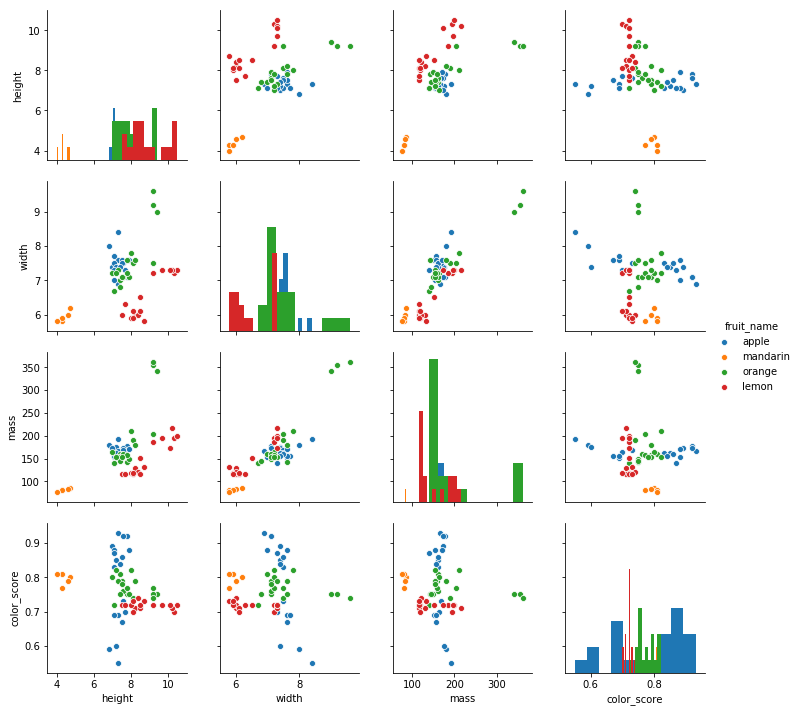

In [20]:
%matplotlib inline

import seaborn as sns
sns.pairplot(fruits[['height', 'width', 'mass', 'color_score', 'fruit_name']], hue='fruit_name', diag_kind="hist")

Wykresy dwuwymiarowe dają pewien pogląd na możliwe granice podziału klas, ale można też spróbować przyjrzeć się temu na wykresie trójwymiarowym.

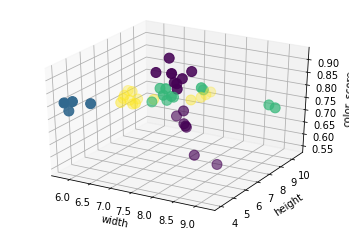

In [21]:
# %matplotlib notebook
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()

# 3D scatter plot
ax = fig.add_subplot(111, projection = '3d')

X = fruits[['height', 'width', 'mass', 'color_score']]
y = fruits['fruit_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

ax.scatter(X_train['width'], X_train['height'], X_train['color_score'], c = y_train, marker = 'o', s=100)
ax.set_xlabel('width')
ax.set_ylabel('height')
ax.set_zlabel('color_score')
plt.show()

### Przygotujmy sobie zbiór trenujący i testowy

In [22]:
from sklearn.model_selection import train_test_split

# Ograniczamy zbiór uczący tylko do trzech cech
X = fruits[['mass', 'width', 'height']]
y = fruits['fruit_label']

***Ex. 1.***

dokonaj podziału na zbiór trenujący i testowy w proporcjach 25%/75%

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Będziemy posługiwać się klasyfikatorem KNN

In [11]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)

In [24]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

### Knn może działać na jakichkolwiek danych
Mogą to byc dane ciągłe, dyskretne, a nawet jakościowe. Np. dla danych jakościowych możemy wybrać odległość (cechy się zgadzają=1, cechy się nie zgadzają=0). Jest to ogromna zaleta. Regresja np. nie może działać na danych jakościowych innych niż binarne.
W knn wszystko sprowadza się do wyboru metryki.

### Dobór metryki jest kluczowy
Tak jak ilość sąsiadów. O metrykach (także tych działających na zmiennych jakościowych), więcej tutaj:

http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html

### Knn jest bardzo dokładny, ale często zbyt wolny
Knn daje zazwyczaj dobre wyniki, ale nie radzi sobie ze sporą ilością danych (przy 100 tys obserwacji ze zbioru trenującego, musimy znaleźć odległość do każdej z tych 100 tys obserwacji). Można stosować triki, które zmniejszają skalę problemu (podział na obszary), ale zawsze problem występuje, szczególnie w modelach produkcyjnych. Oczywiście nim więcej danych tym dokładniej działa knn (przy regresjii całe mnóstwo danych nie musi dawać istotnie lepszego wyniku niż np 100). Przy dobrym doborze k i metryki knn może działa czasami bardzo skutecznie, mimo wyjątkowej prostoty

### Knn nie ma wielu parametrów
W zasadzie to miara odległości oraz ilość sąsiadów. Znalezienie optymalnych parametrów jest często prostsze niż np. w sieciach neuronowych, gdzie parametrów jest często kilkadziesiąt i więcej.

### Knn jest wrażliwy na skalowanie
O tym w punkcie niżej :)

Zobaczmy jak sobie radzi nas klasyfikator na danych testowych

In [25]:
knn.score(X_test, y_test)

0.5333333333333333

***Overfitting czy underfitting?***

A jak sobie poradzi nas klasyfikator na nowej obserwacji?

In [26]:
# przykład pierwszy: mały owoc ważący 20g, szerokosc 4.3 cm, wysokość to 5.5 cm
fruit_prediction = knn.predict([[20, 4.3, 5.5]])
lookup_fruit_name[fruit_prediction[0]]

'mandarin'

In [27]:
# second example: a larger, elongated fruit with mass 100g, width 6.3 cm, height 8.5 cm
fruit_prediction = knn.predict([[100, 6.3, 8.5]])
lookup_fruit_name[fruit_prediction[0]]

'lemon'

### Jak bardzo wrażliwe na wybór parametru k jest klasyfikator kNN ?

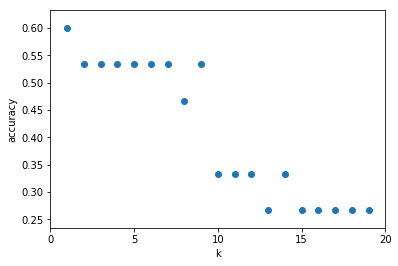

In [28]:
k_range = range(1,20)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))

plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20]);

### Jak bardzo wrażliwy jest kNN na proporcje podziału zbioru train/test?

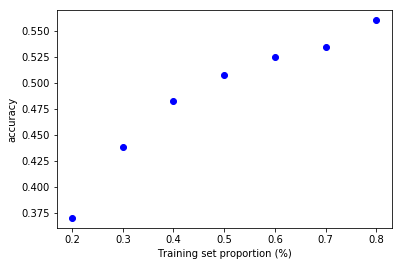

In [29]:
t = [0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]

knn = KNeighborsClassifier(n_neighbors = 5)

plt.figure()

for s in t:

    scores = []
    for i in range(1,1000):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-s)
        knn.fit(X_train, y_train)
        scores.append(knn.score(X_test, y_test))
    plt.plot(s, np.mean(scores), 'bo')

plt.xlabel('Training set proportion (%)')
plt.ylabel('accuracy');

## Skalowanie danych

Wyobraźmy sobie następującą sytuację:

Chcemy dokonać klasyfikacji, czy wnioskodawca spłaci kredyt (etykieta). Dysponujemy danymi historycznymi, które obejmują:
    
* ile dana osoba zarabia w skali rocznej w złotówkach (zmienna x)
* ile dana osoba ma członków rodziny (zmienna y)
* czy ostatecznie dana osoba spłaciła kredyt

Bierzemy zwykłą odległość euklidesową jako metrykę. Ostatecznie okazuje się, że na działanie naszego algorytmu ilośc członków rodziny nie ma zupełnie znaczenia. Dlaczego tak się dzieje? Odległość euklidesowa:

![](fruits/edist.png)

zdominowana będzie całkowicie przez zarobki, ponieważ dla 
* osoby 1 z zarobkami 56800 i 10 członkami rodziny
* osoby 2 z zarobkami 56900 i 0 członkami rodziny

mamy pod pierwiastkiem:

$$(56800 - 56900 ) ^2 + (10 - 0 ) ^ 2 = 100^2 + 10 ^2 = 10000 + 10= 10010$$


Czyli ilość członków rodziny nie ma prawie wpływu na wynik, natomiast mała różnica w zarobkach (100zł) ma ogromny wpływ

Osoba 1 będzie bliżej osoby 2, niż takiej osoby:
* osoba 3 z zrobkami 56950 i 11 członkami rodziny

ponieważ:

$$(56800 - 56950 ) ^2 + (10 - 11 ) ^ 2 = 150^2 + 1 ^2 = 22500 + 1 = 22501$$

chociaż osoba 1 ma podobny profil  do osoby 3 (duża rodzina, zarobki różnią się jedynie 150 zł w skali roku), to według knn bliżej jej do osoby 2 (bo różnica zarobków wynosi 100, a nie 150 zł w skali roku)

### Co z tym zrobić? 
Najlepiej przeskalować dane, żeby wszystkie cechy przyjmowały wartości w tej samej skali, np 0-1. Niekoniecznie zawsze jest to potrzebne, gdyż czasami chcemy żeby jedna cecha była dominująca albo posługujemy się danymi w jednej skali (wszystkie wymiary w metrach).


W Pythonie łatwo przeskalować dane dzięki modułowi sklearn.preprocessing (jest wiele różnych skalerów).

Sytuację dobrze ilustruje:

![przed skalowaniem](fruits/knn-ns.png)

![po skalowaniu](fruits/knn-s.png)

### Co z resztą algorytmów?

Wszystko zależy od algorytmu. Knn jest niesamowicie wrażliwy na skalowanie (jak i dobór metryki). Regresja liniowa daje niezależny wynik od przeskalowania (rekompensuje skalowanie doborem parametrów) podobnie jak drzewa decyzyjne (które ustawiają sztywne progi w każdym węźle). Sieci neuronowe teoretycznie są zbieżne niezależnie od przeskalowania danych, ale na przeskalowanych danych zbiegają szybciej, zatem zdecydowanie warto je przeskalować.
